Accuracy Score: 0.84114

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.82      0.90     85062
        True       0.48      0.97      0.65     14938

    accuracy                           0.84    100000
   macro avg       0.74      0.89      0.77    100000
weighted avg       0.92      0.84      0.86    100000

Confusion Matrix:
 [[69660 15402]
 [  484 14454]]
ROC AUC Score: 0.9683285160899184


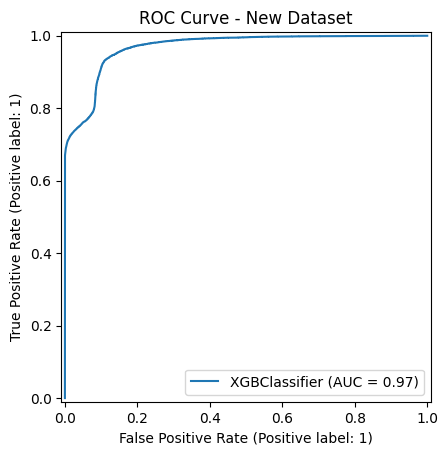

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Load the pre-trained model and scaler
model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# Load new dataset
df_new = pd.read_csv('new_transactions.csv')  # Replace with your file path

# Preprocess: create features same as during training
df_new['txn_date'] = pd.to_datetime(df_new['txn_date'])
df_new['hour_of_day'] = df_new['txn_date'].dt.hour
df_new['day_of_week'] = df_new['txn_date'].dt.dayofweek

# Behavioral features
user_avg = df_new.groupby('userId').agg(
    avg_amount=('amount', 'mean'),
    avg_lat=('txn_latitude', 'mean'),
    avg_lon=('txn_longitude', 'mean')
).reset_index()

df_new = pd.merge(df_new, user_avg, on='userId', how='left')

# Distance feature
df_new['distance'] = np.sqrt(
    (df_new['txn_latitude'] - df_new['avg_lat'])**2 +
    (df_new['txn_longitude'] - df_new['avg_lon'])**2
)

# Features and target
features = ['amount', 'hour_of_day', 'day_of_week', 'avg_amount', 'distance']
X_new = df_new[features]
y_new = df_new['is_anomaly']

# Scale the features
X_new = scaler.transform(X_new)

# Make predictions
y_pred = model.predict(X_new)
y_proba = model.predict_proba(X_new)[:, 1]

# Evaluation metrics
print("Accuracy Score:", accuracy_score(y_new, y_pred))
print("\nClassification Report:\n", classification_report(y_new, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_new, y_pred))
print("ROC AUC Score:", roc_auc_score(y_new, y_proba))

# Plot ROC curve
RocCurveDisplay.from_estimator(model, X_new, y_new)
plt.title("ROC Curve - New Dataset")
plt.show()
